# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
%tensorflow_version 1.x

import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

TensorFlow 1.x selected.


In [2]:
!rm -r *
!wget -q https://raw.githubusercontent.com/bhupendpatil/Practice/master/Deep%20Learning/Generative%20Adversarial%20Networks/Generate%20Faces/problem_unittests.py
!wget -q https://raw.githubusercontent.com/bhupendpatil/Practice/master/Deep%20Learning/Generative%20Adversarial%20Networks/Generate%20Faces/helper.py

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)
print("Done")

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:11<00:00, 5.18kFile/s]


Extracting celeba...
Done


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

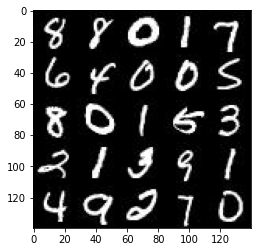

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

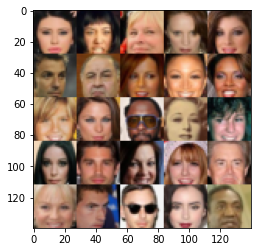

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
#import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    !nvidia-smi

TensorFlow Version: 1.15.2
Default GPU Device: /device:GPU:0
Fri Jan 29 16:35:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |    265MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                           

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name="inpur_real")
    inputs_z = tf.placeholder(tf.float32,(None,z_dim),name="inputs_z")
    learn_rate = tf.placeholder(tf.float32,name="learn_rate")

    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)


Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("discriminator",reuse=reuse):
      i1 = tf.layers.conv2d(images,32,5,strides=2,padding="same")
      i1 = tf.maximum(alpha*i1,i1)

      i2 = tf.layers.conv2d(i1,64,5,strides=2,padding="same")
      i2 = tf.layers.batch_normalization(i2,training=True)
      i2 = tf.maximum(alpha*i2,i2)

      i3 = tf.layers.conv2d(i2,128,5,strides=2,padding="same")
      i3 = tf.layers.batch_normalization(i3,training=True)
      i3 = tf.maximum(alpha*i3,i3)

      i4 = tf.layers.conv2d(i3,256,5,strides=2,padding="same")
      i4 = tf.layers.batch_normalization(i3,training=True)
      i4 = tf.maximum(alpha*i3,i3)

      flat = tf.reshape(i3,(-1,2*2*256))
      logits = tf.layers.dense(flat,1)
      out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/content/problem_unittests.py", line 38, in _check_input
    '{} has bad name.  Found name {}'.format(display_name, tensor.name)  File "/content/problem_unittests.py", line 27, in _assert_tensor_shape
    '{} has wrong shape.  Found {}'.format(display_name, tensor_shape)  File "/tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/check_ops.py", line 1155, in assert_rank
    return assert_op  File "/tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/check_ops.py", line 1060, in _assert_rank_condition
    return control_flow_ops.Assert(condition, data, summarize=summarize)  File "/tensorflow-1.15.2/python3.6/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_sh

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator",reuse=not is_train):
      i1 = tf.layers.dense(z,4*4*512)
      i1 = tf.reshape(i1,(-1,4,4,512))
      i1 = tf.layers.batch_normalization(i1,training=is_train)
      i1 = tf.maximum(alpha*i1,i1)

      i2 = tf.layers.conv2d_transpose(i1,128,4,strides=1,padding="valid")
      i2 = tf.layers.batch_normalization(i2,training=is_train)
      i2 = tf.maximum(alpha*i2,i2)

      i3 = tf.layers.conv2d_transpose(i2,64,4,strides=2,padding="same")
      i3 = tf.layers.batch_normalization(i3,training=is_train)
      i3 = tf.maximum(alpha*i3,i3)

      i4 = tf.layers.conv2d_transpose(i3,32,5,strides=2,padding="same")
      i4 = tf.layers.batch_normalization(i4,training=is_train)
      i4 = tf.maximum(alpha*i4,i4)

      logits = tf.layers.conv2d_transpose(i4,out_channel_dim,3,strides=1,padding="same")

      out = tf.tanh(logits)

      return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [i for i in t_vars if i.name.startswith("generator")]
    d_vars = [i for i in t_vars if i.name.startswith("discriminator")]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
      g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)


Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _,image_width,image_height,image_channels = data_shape
    input_real,input_z,learn_rate = model_inputs(image_width,image_height,image_channels,z_dim)
    d_loss,g_loss = model_loss(input_real,input_z,image_channels)
    d_opt,g_opt = model_opt(d_loss,g_loss,learn_rate,beta1)

    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *=2
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))

                _ = sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z,learn_rate:learning_rate})
                
                _ = sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,learn_rate:learning_rate})

                if steps%10==0:
                  train_loss_d = d_loss.eval({input_z:batch_z,input_real:batch_images})
                  train_loss_g = g_loss.eval({input_z:batch_z})

                  print("Epoch {}/{}...".format(epoch_i+1,epochs),
                        "Generator Loss: {:.4f}".format(train_loss_g),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d))
                
                if steps%100==0:
                  show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Generator Loss: 5.3633 Discriminator Loss: 3.0263...
Epoch 1/2... Generator Loss: 0.7931 Discriminator Loss: 1.0737...
Epoch 1/2... Generator Loss: 1.3851 Discriminator Loss: 0.5344...
Epoch 1/2... Generator Loss: 1.0757 Discriminator Loss: 0.7110...
Epoch 1/2... Generator Loss: 2.2228 Discriminator Loss: 2.5700...
Epoch 1/2... Generator Loss: 5.9162 Discriminator Loss: 6.4872...
Epoch 1/2... Generator Loss: 0.5439 Discriminator Loss: 1.7973...
Epoch 1/2... Generator Loss: 0.5561 Discriminator Loss: 1.5098...
Epoch 1/2... Generator Loss: 1.2450 Discriminator Loss: 1.6569...
Epoch 1/2... Generator Loss: 1.0576 Discriminator Loss: 1.4000...


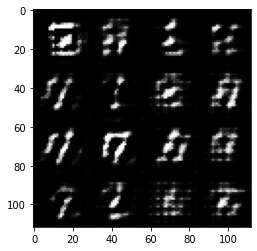

Epoch 1/2... Generator Loss: 1.3209 Discriminator Loss: 1.5060...
Epoch 1/2... Generator Loss: 1.0382 Discriminator Loss: 1.4035...
Epoch 1/2... Generator Loss: 1.0330 Discriminator Loss: 1.4164...
Epoch 1/2... Generator Loss: 1.0372 Discriminator Loss: 1.5083...
Epoch 1/2... Generator Loss: 0.6837 Discriminator Loss: 1.3822...
Epoch 1/2... Generator Loss: 0.2331 Discriminator Loss: 1.8226...
Epoch 1/2... Generator Loss: 0.4675 Discriminator Loss: 1.4211...
Epoch 1/2... Generator Loss: 0.5191 Discriminator Loss: 1.4703...
Epoch 1/2... Generator Loss: 0.5388 Discriminator Loss: 1.3094...
Epoch 1/2... Generator Loss: 0.4946 Discriminator Loss: 1.3630...


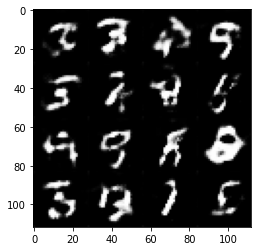

Epoch 1/2... Generator Loss: 0.5289 Discriminator Loss: 1.5332...
Epoch 1/2... Generator Loss: 1.1390 Discriminator Loss: 1.5295...
Epoch 1/2... Generator Loss: 0.9915 Discriminator Loss: 1.4358...
Epoch 1/2... Generator Loss: 0.6690 Discriminator Loss: 1.4335...
Epoch 1/2... Generator Loss: 1.0168 Discriminator Loss: 1.3682...
Epoch 1/2... Generator Loss: 0.9255 Discriminator Loss: 1.4072...
Epoch 1/2... Generator Loss: 0.8003 Discriminator Loss: 1.4046...
Epoch 1/2... Generator Loss: 0.4436 Discriminator Loss: 1.4616...
Epoch 1/2... Generator Loss: 0.5248 Discriminator Loss: 1.3936...
Epoch 1/2... Generator Loss: 0.4810 Discriminator Loss: 1.4353...


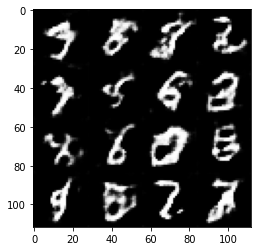

Epoch 1/2... Generator Loss: 0.6029 Discriminator Loss: 1.3657...
Epoch 1/2... Generator Loss: 0.7526 Discriminator Loss: 1.2771...
Epoch 1/2... Generator Loss: 0.8178 Discriminator Loss: 1.3662...
Epoch 1/2... Generator Loss: 0.7303 Discriminator Loss: 1.3533...
Epoch 1/2... Generator Loss: 0.5430 Discriminator Loss: 1.4407...
Epoch 1/2... Generator Loss: 0.9538 Discriminator Loss: 1.4267...
Epoch 1/2... Generator Loss: 0.9052 Discriminator Loss: 1.3704...
Epoch 1/2... Generator Loss: 0.7954 Discriminator Loss: 1.3365...
Epoch 1/2... Generator Loss: 0.8415 Discriminator Loss: 1.3104...
Epoch 1/2... Generator Loss: 0.7748 Discriminator Loss: 1.3518...


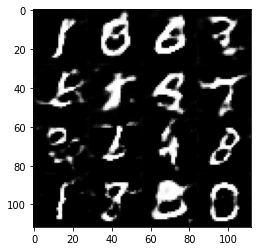

Epoch 1/2... Generator Loss: 0.7919 Discriminator Loss: 1.4160...
Epoch 1/2... Generator Loss: 0.7218 Discriminator Loss: 1.3487...
Epoch 1/2... Generator Loss: 0.9929 Discriminator Loss: 1.3599...
Epoch 1/2... Generator Loss: 0.7223 Discriminator Loss: 1.3412...
Epoch 1/2... Generator Loss: 0.9328 Discriminator Loss: 1.3806...
Epoch 1/2... Generator Loss: 0.7572 Discriminator Loss: 1.2880...
Epoch 1/2... Generator Loss: 0.7123 Discriminator Loss: 1.3576...
Epoch 1/2... Generator Loss: 0.7205 Discriminator Loss: 1.4279...
Epoch 1/2... Generator Loss: 0.8165 Discriminator Loss: 1.3638...
Epoch 1/2... Generator Loss: 1.0629 Discriminator Loss: 1.4395...


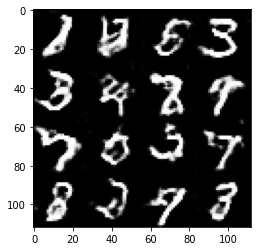

Epoch 1/2... Generator Loss: 0.8052 Discriminator Loss: 1.3157...
Epoch 1/2... Generator Loss: 0.8431 Discriminator Loss: 1.3859...
Epoch 1/2... Generator Loss: 0.5473 Discriminator Loss: 1.4260...
Epoch 1/2... Generator Loss: 0.5771 Discriminator Loss: 1.3462...
Epoch 1/2... Generator Loss: 0.8512 Discriminator Loss: 1.2383...
Epoch 1/2... Generator Loss: 0.9595 Discriminator Loss: 1.3038...
Epoch 1/2... Generator Loss: 0.9564 Discriminator Loss: 1.4137...
Epoch 1/2... Generator Loss: 0.4615 Discriminator Loss: 1.4521...
Epoch 1/2... Generator Loss: 0.6667 Discriminator Loss: 1.3288...
Epoch 1/2... Generator Loss: 0.5456 Discriminator Loss: 1.4099...


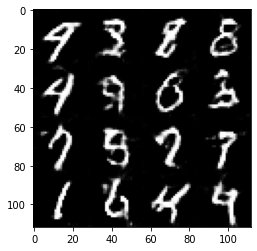

Epoch 1/2... Generator Loss: 0.4291 Discriminator Loss: 1.4529...
Epoch 1/2... Generator Loss: 0.5433 Discriminator Loss: 1.3633...
Epoch 1/2... Generator Loss: 0.4355 Discriminator Loss: 1.4582...
Epoch 1/2... Generator Loss: 0.4837 Discriminator Loss: 1.4038...
Epoch 1/2... Generator Loss: 0.6961 Discriminator Loss: 1.2413...
Epoch 1/2... Generator Loss: 0.4389 Discriminator Loss: 1.5153...
Epoch 1/2... Generator Loss: 0.5447 Discriminator Loss: 1.3635...
Epoch 1/2... Generator Loss: 0.5999 Discriminator Loss: 1.3111...
Epoch 1/2... Generator Loss: 0.8797 Discriminator Loss: 1.3291...
Epoch 1/2... Generator Loss: 0.7692 Discriminator Loss: 1.3855...


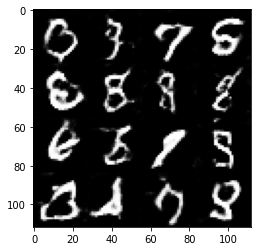

Epoch 1/2... Generator Loss: 0.8637 Discriminator Loss: 1.3462...
Epoch 1/2... Generator Loss: 0.9147 Discriminator Loss: 1.2839...
Epoch 1/2... Generator Loss: 0.6844 Discriminator Loss: 1.2771...
Epoch 1/2... Generator Loss: 1.1420 Discriminator Loss: 1.4865...
Epoch 1/2... Generator Loss: 0.7902 Discriminator Loss: 1.2608...
Epoch 1/2... Generator Loss: 0.7171 Discriminator Loss: 1.3153...
Epoch 1/2... Generator Loss: 0.6979 Discriminator Loss: 1.3122...
Epoch 1/2... Generator Loss: 0.5958 Discriminator Loss: 1.3833...
Epoch 1/2... Generator Loss: 0.5817 Discriminator Loss: 1.3217...
Epoch 1/2... Generator Loss: 0.9596 Discriminator Loss: 1.2523...


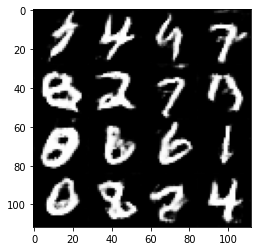

Epoch 1/2... Generator Loss: 0.7654 Discriminator Loss: 1.2894...
Epoch 1/2... Generator Loss: 0.6870 Discriminator Loss: 1.2322...
Epoch 1/2... Generator Loss: 0.5659 Discriminator Loss: 1.2670...
Epoch 1/2... Generator Loss: 0.6799 Discriminator Loss: 1.2960...
Epoch 1/2... Generator Loss: 0.7520 Discriminator Loss: 1.4088...
Epoch 1/2... Generator Loss: 0.4630 Discriminator Loss: 1.3918...
Epoch 1/2... Generator Loss: 0.6696 Discriminator Loss: 1.3095...
Epoch 1/2... Generator Loss: 0.6648 Discriminator Loss: 1.3114...
Epoch 1/2... Generator Loss: 0.5583 Discriminator Loss: 1.3312...
Epoch 1/2... Generator Loss: 0.5399 Discriminator Loss: 1.3538...


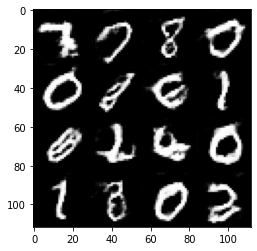

Epoch 1/2... Generator Loss: 0.6258 Discriminator Loss: 1.3522...
Epoch 1/2... Generator Loss: 0.9093 Discriminator Loss: 1.3213...
Epoch 1/2... Generator Loss: 1.0407 Discriminator Loss: 1.3066...
Epoch 2/2... Generator Loss: 0.8017 Discriminator Loss: 1.2796...
Epoch 2/2... Generator Loss: 0.8007 Discriminator Loss: 1.3515...
Epoch 2/2... Generator Loss: 0.9375 Discriminator Loss: 1.2847...
Epoch 2/2... Generator Loss: 0.4835 Discriminator Loss: 1.3685...
Epoch 2/2... Generator Loss: 0.4907 Discriminator Loss: 1.3936...
Epoch 2/2... Generator Loss: 0.5739 Discriminator Loss: 1.2527...
Epoch 2/2... Generator Loss: 0.7438 Discriminator Loss: 1.3695...


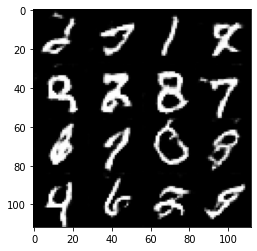

Epoch 2/2... Generator Loss: 0.7736 Discriminator Loss: 1.1663...
Epoch 2/2... Generator Loss: 0.4276 Discriminator Loss: 1.4929...
Epoch 2/2... Generator Loss: 0.7358 Discriminator Loss: 1.2348...
Epoch 2/2... Generator Loss: 1.0909 Discriminator Loss: 1.2891...
Epoch 2/2... Generator Loss: 0.7248 Discriminator Loss: 1.2821...
Epoch 2/2... Generator Loss: 0.5766 Discriminator Loss: 1.2376...
Epoch 2/2... Generator Loss: 0.6555 Discriminator Loss: 1.3230...
Epoch 2/2... Generator Loss: 0.7918 Discriminator Loss: 1.3062...
Epoch 2/2... Generator Loss: 0.9566 Discriminator Loss: 1.2810...
Epoch 2/2... Generator Loss: 0.6593 Discriminator Loss: 1.3604...


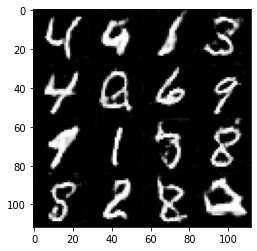

Epoch 2/2... Generator Loss: 0.5256 Discriminator Loss: 1.4205...
Epoch 2/2... Generator Loss: 0.7840 Discriminator Loss: 1.2770...
Epoch 2/2... Generator Loss: 0.8374 Discriminator Loss: 1.3652...
Epoch 2/2... Generator Loss: 0.7723 Discriminator Loss: 1.3150...
Epoch 2/2... Generator Loss: 0.8282 Discriminator Loss: 1.1853...
Epoch 2/2... Generator Loss: 0.6293 Discriminator Loss: 1.2922...
Epoch 2/2... Generator Loss: 0.5700 Discriminator Loss: 1.2570...
Epoch 2/2... Generator Loss: 0.9630 Discriminator Loss: 1.2960...
Epoch 2/2... Generator Loss: 0.6818 Discriminator Loss: 1.2073...
Epoch 2/2... Generator Loss: 0.8115 Discriminator Loss: 1.2480...


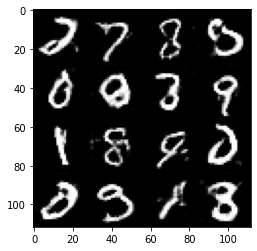

Epoch 2/2... Generator Loss: 1.0197 Discriminator Loss: 1.3025...
Epoch 2/2... Generator Loss: 0.8088 Discriminator Loss: 1.2208...
Epoch 2/2... Generator Loss: 1.0939 Discriminator Loss: 1.2723...
Epoch 2/2... Generator Loss: 0.7214 Discriminator Loss: 1.3913...
Epoch 2/2... Generator Loss: 0.9160 Discriminator Loss: 1.2761...
Epoch 2/2... Generator Loss: 0.6325 Discriminator Loss: 1.2783...
Epoch 2/2... Generator Loss: 0.5231 Discriminator Loss: 1.3693...
Epoch 2/2... Generator Loss: 0.4939 Discriminator Loss: 1.3878...
Epoch 2/2... Generator Loss: 0.9745 Discriminator Loss: 1.1804...
Epoch 2/2... Generator Loss: 1.0416 Discriminator Loss: 1.4255...


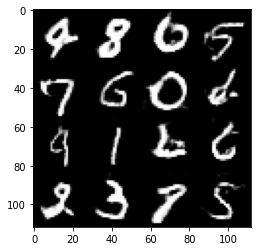

Epoch 2/2... Generator Loss: 0.6582 Discriminator Loss: 1.3618...
Epoch 2/2... Generator Loss: 0.5747 Discriminator Loss: 1.3617...
Epoch 2/2... Generator Loss: 0.7897 Discriminator Loss: 1.3037...
Epoch 2/2... Generator Loss: 0.7769 Discriminator Loss: 1.3050...
Epoch 2/2... Generator Loss: 0.7416 Discriminator Loss: 1.2830...
Epoch 2/2... Generator Loss: 0.9791 Discriminator Loss: 1.2190...
Epoch 2/2... Generator Loss: 0.6570 Discriminator Loss: 1.2383...
Epoch 2/2... Generator Loss: 0.5477 Discriminator Loss: 1.3067...
Epoch 2/2... Generator Loss: 0.5663 Discriminator Loss: 1.3144...
Epoch 2/2... Generator Loss: 0.3845 Discriminator Loss: 1.5759...


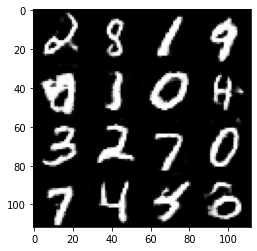

Epoch 2/2... Generator Loss: 0.6898 Discriminator Loss: 1.1867...
Epoch 2/2... Generator Loss: 0.6399 Discriminator Loss: 1.2995...
Epoch 2/2... Generator Loss: 0.4964 Discriminator Loss: 1.3347...
Epoch 2/2... Generator Loss: 0.4127 Discriminator Loss: 1.3872...
Epoch 2/2... Generator Loss: 0.5924 Discriminator Loss: 1.2052...
Epoch 2/2... Generator Loss: 0.6237 Discriminator Loss: 1.3265...
Epoch 2/2... Generator Loss: 0.6813 Discriminator Loss: 1.1973...
Epoch 2/2... Generator Loss: 0.4454 Discriminator Loss: 1.3939...
Epoch 2/2... Generator Loss: 0.5426 Discriminator Loss: 1.3487...
Epoch 2/2... Generator Loss: 0.8097 Discriminator Loss: 1.2304...


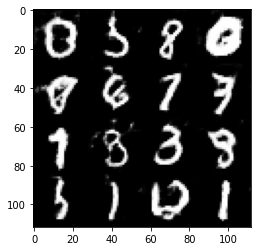

Epoch 2/2... Generator Loss: 0.6584 Discriminator Loss: 1.3450...
Epoch 2/2... Generator Loss: 1.3428 Discriminator Loss: 1.5609...
Epoch 2/2... Generator Loss: 0.5879 Discriminator Loss: 1.3241...
Epoch 2/2... Generator Loss: 0.8069 Discriminator Loss: 1.1767...
Epoch 2/2... Generator Loss: 1.2542 Discriminator Loss: 1.4461...
Epoch 2/2... Generator Loss: 0.7116 Discriminator Loss: 1.2442...
Epoch 2/2... Generator Loss: 0.8177 Discriminator Loss: 1.1725...
Epoch 2/2... Generator Loss: 1.4445 Discriminator Loss: 1.7278...
Epoch 2/2... Generator Loss: 0.7350 Discriminator Loss: 1.2385...
Epoch 2/2... Generator Loss: 1.0093 Discriminator Loss: 1.1020...


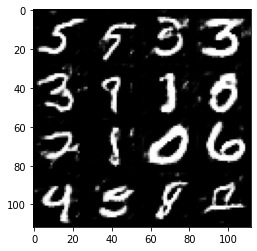

Epoch 2/2... Generator Loss: 0.6796 Discriminator Loss: 1.2744...
Epoch 2/2... Generator Loss: 0.9004 Discriminator Loss: 1.2257...
Epoch 2/2... Generator Loss: 1.3108 Discriminator Loss: 1.4884...
Epoch 2/2... Generator Loss: 0.7916 Discriminator Loss: 1.2260...
Epoch 2/2... Generator Loss: 0.6912 Discriminator Loss: 1.1440...
Epoch 2/2... Generator Loss: 0.6432 Discriminator Loss: 1.2327...
Epoch 2/2... Generator Loss: 1.3621 Discriminator Loss: 1.3641...
Epoch 2/2... Generator Loss: 0.9126 Discriminator Loss: 1.0310...
Epoch 2/2... Generator Loss: 0.7074 Discriminator Loss: 1.3534...
Epoch 2/2... Generator Loss: 0.8719 Discriminator Loss: 1.2521...


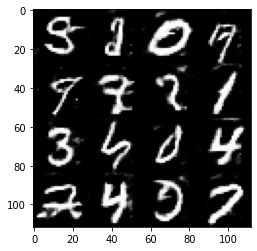

Epoch 2/2... Generator Loss: 0.8260 Discriminator Loss: 1.1530...
Epoch 2/2... Generator Loss: 0.9610 Discriminator Loss: 1.2132...
Epoch 2/2... Generator Loss: 0.6878 Discriminator Loss: 1.2627...
Epoch 2/2... Generator Loss: 1.2809 Discriminator Loss: 1.3929...
Epoch 2/2... Generator Loss: 1.0294 Discriminator Loss: 1.1497...
Epoch 2/2... Generator Loss: 0.7541 Discriminator Loss: 1.2835...
Epoch 2/2... Generator Loss: 0.6021 Discriminator Loss: 1.2454...
Epoch 2/2... Generator Loss: 0.7944 Discriminator Loss: 1.1746...
Epoch 2/2... Generator Loss: 0.7339 Discriminator Loss: 1.2390...
Epoch 2/2... Generator Loss: 0.7418 Discriminator Loss: 1.1882...


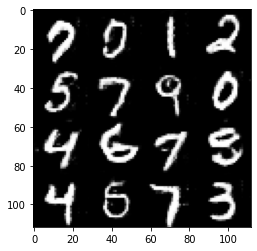

Epoch 2/2... Generator Loss: 0.3950 Discriminator Loss: 1.4954...
Epoch 2/2... Generator Loss: 0.6250 Discriminator Loss: 1.1674...
Epoch 2/2... Generator Loss: 1.0477 Discriminator Loss: 1.2964...
Epoch 2/2... Generator Loss: 0.9429 Discriminator Loss: 1.1499...
Epoch 2/2... Generator Loss: 0.3489 Discriminator Loss: 1.5443...
Epoch 2/2... Generator Loss: 0.5669 Discriminator Loss: 1.2542...
Epoch 2/2... Generator Loss: 0.6873 Discriminator Loss: 1.3773...


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Generator Loss: 0.5409 Discriminator Loss: 1.4509...
Epoch 1/1... Generator Loss: 0.1194 Discriminator Loss: 2.4088...
Epoch 1/1... Generator Loss: 0.1130 Discriminator Loss: 2.5976...
Epoch 1/1... Generator Loss: 0.7511 Discriminator Loss: 1.0486...
Epoch 1/1... Generator Loss: 1.3332 Discriminator Loss: 1.0406...
Epoch 1/1... Generator Loss: 2.5691 Discriminator Loss: 0.9838...
Epoch 1/1... Generator Loss: 0.9962 Discriminator Loss: 1.2717...
Epoch 1/1... Generator Loss: 1.5662 Discriminator Loss: 1.2931...
Epoch 1/1... Generator Loss: 0.9418 Discriminator Loss: 1.2697...
Epoch 1/1... Generator Loss: 1.1242 Discriminator Loss: 1.4876...


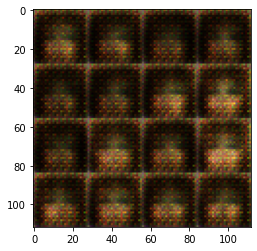

Epoch 1/1... Generator Loss: 0.5687 Discriminator Loss: 1.5773...
Epoch 1/1... Generator Loss: 0.4343 Discriminator Loss: 1.5662...
Epoch 1/1... Generator Loss: 0.7118 Discriminator Loss: 1.3680...
Epoch 1/1... Generator Loss: 0.4555 Discriminator Loss: 1.4732...
Epoch 1/1... Generator Loss: 0.8506 Discriminator Loss: 1.2254...
Epoch 1/1... Generator Loss: 0.8990 Discriminator Loss: 1.2331...
Epoch 1/1... Generator Loss: 0.9142 Discriminator Loss: 1.3260...
Epoch 1/1... Generator Loss: 1.0870 Discriminator Loss: 1.3984...
Epoch 1/1... Generator Loss: 1.0243 Discriminator Loss: 1.1752...
Epoch 1/1... Generator Loss: 1.5904 Discriminator Loss: 1.2883...


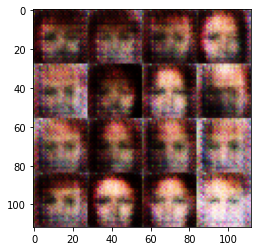

Epoch 1/1... Generator Loss: 0.9152 Discriminator Loss: 1.1034...
Epoch 1/1... Generator Loss: 1.7984 Discriminator Loss: 1.3421...
Epoch 1/1... Generator Loss: 1.4924 Discriminator Loss: 1.2956...
Epoch 1/1... Generator Loss: 1.4524 Discriminator Loss: 0.9239...
Epoch 1/1... Generator Loss: 1.6625 Discriminator Loss: 0.8258...
Epoch 1/1... Generator Loss: 1.2669 Discriminator Loss: 0.9518...
Epoch 1/1... Generator Loss: 1.0725 Discriminator Loss: 1.6676...
Epoch 1/1... Generator Loss: 0.5907 Discriminator Loss: 1.3846...
Epoch 1/1... Generator Loss: 0.5586 Discriminator Loss: 1.1752...
Epoch 1/1... Generator Loss: 0.6319 Discriminator Loss: 1.2561...


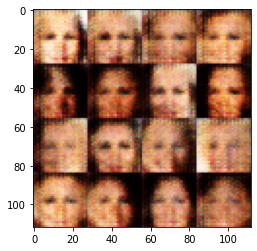

Epoch 1/1... Generator Loss: 0.5295 Discriminator Loss: 1.3369...
Epoch 1/1... Generator Loss: 0.3910 Discriminator Loss: 1.5006...
Epoch 1/1... Generator Loss: 1.1997 Discriminator Loss: 1.7559...
Epoch 1/1... Generator Loss: 1.3918 Discriminator Loss: 0.9528...
Epoch 1/1... Generator Loss: 1.0080 Discriminator Loss: 1.0579...
Epoch 1/1... Generator Loss: 1.1767 Discriminator Loss: 1.6161...
Epoch 1/1... Generator Loss: 1.0662 Discriminator Loss: 1.0788...
Epoch 1/1... Generator Loss: 1.3473 Discriminator Loss: 1.5261...
Epoch 1/1... Generator Loss: 0.8625 Discriminator Loss: 1.1244...
Epoch 1/1... Generator Loss: 0.9409 Discriminator Loss: 1.3303...


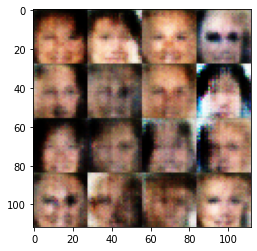

Epoch 1/1... Generator Loss: 0.7672 Discriminator Loss: 1.4895...
Epoch 1/1... Generator Loss: 0.9598 Discriminator Loss: 1.4962...
Epoch 1/1... Generator Loss: 0.2556 Discriminator Loss: 1.7541...
Epoch 1/1... Generator Loss: 0.8388 Discriminator Loss: 1.3311...
Epoch 1/1... Generator Loss: 0.5789 Discriminator Loss: 1.3443...
Epoch 1/1... Generator Loss: 1.0420 Discriminator Loss: 1.2714...
Epoch 1/1... Generator Loss: 0.7624 Discriminator Loss: 1.1802...
Epoch 1/1... Generator Loss: 1.2861 Discriminator Loss: 1.0469...
Epoch 1/1... Generator Loss: 0.6909 Discriminator Loss: 1.3409...
Epoch 1/1... Generator Loss: 0.7340 Discriminator Loss: 1.3465...


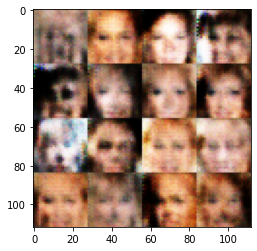

Epoch 1/1... Generator Loss: 0.5346 Discriminator Loss: 1.3726...
Epoch 1/1... Generator Loss: 0.4427 Discriminator Loss: 1.4694...
Epoch 1/1... Generator Loss: 0.8055 Discriminator Loss: 1.2222...
Epoch 1/1... Generator Loss: 0.9616 Discriminator Loss: 1.1633...
Epoch 1/1... Generator Loss: 0.7073 Discriminator Loss: 1.2915...
Epoch 1/1... Generator Loss: 0.5379 Discriminator Loss: 1.3981...
Epoch 1/1... Generator Loss: 0.5733 Discriminator Loss: 1.2817...
Epoch 1/1... Generator Loss: 0.7934 Discriminator Loss: 1.3838...
Epoch 1/1... Generator Loss: 0.4578 Discriminator Loss: 1.4675...
Epoch 1/1... Generator Loss: 0.6043 Discriminator Loss: 1.2760...


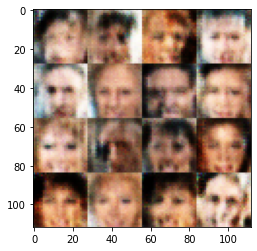

Epoch 1/1... Generator Loss: 0.7049 Discriminator Loss: 1.4046...
Epoch 1/1... Generator Loss: 1.0774 Discriminator Loss: 1.0330...
Epoch 1/1... Generator Loss: 0.6424 Discriminator Loss: 1.4428...
Epoch 1/1... Generator Loss: 0.7971 Discriminator Loss: 1.2998...
Epoch 1/1... Generator Loss: 0.6177 Discriminator Loss: 1.3968...
Epoch 1/1... Generator Loss: 0.6422 Discriminator Loss: 1.3440...
Epoch 1/1... Generator Loss: 0.6714 Discriminator Loss: 1.4093...
Epoch 1/1... Generator Loss: 0.6587 Discriminator Loss: 1.3694...
Epoch 1/1... Generator Loss: 0.5855 Discriminator Loss: 1.3799...
Epoch 1/1... Generator Loss: 0.7106 Discriminator Loss: 1.3257...


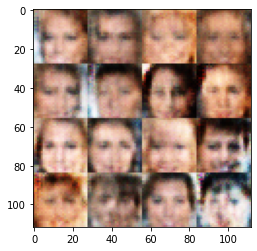

Epoch 1/1... Generator Loss: 0.5517 Discriminator Loss: 1.4643...
Epoch 1/1... Generator Loss: 0.8430 Discriminator Loss: 1.2027...
Epoch 1/1... Generator Loss: 0.6838 Discriminator Loss: 1.3350...
Epoch 1/1... Generator Loss: 0.3872 Discriminator Loss: 1.4846...
Epoch 1/1... Generator Loss: 0.6542 Discriminator Loss: 1.3585...
Epoch 1/1... Generator Loss: 0.7014 Discriminator Loss: 1.3503...
Epoch 1/1... Generator Loss: 0.7130 Discriminator Loss: 1.2677...
Epoch 1/1... Generator Loss: 0.6497 Discriminator Loss: 1.3017...
Epoch 1/1... Generator Loss: 0.7712 Discriminator Loss: 1.3528...
Epoch 1/1... Generator Loss: 0.4477 Discriminator Loss: 1.4435...


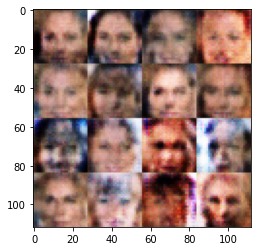

Epoch 1/1... Generator Loss: 0.4785 Discriminator Loss: 1.4279...
Epoch 1/1... Generator Loss: 0.8191 Discriminator Loss: 1.5177...
Epoch 1/1... Generator Loss: 0.6057 Discriminator Loss: 1.3555...
Epoch 1/1... Generator Loss: 0.5273 Discriminator Loss: 1.4423...
Epoch 1/1... Generator Loss: 0.4735 Discriminator Loss: 1.3818...
Epoch 1/1... Generator Loss: 0.7570 Discriminator Loss: 1.4189...
Epoch 1/1... Generator Loss: 0.9230 Discriminator Loss: 1.1394...
Epoch 1/1... Generator Loss: 0.6301 Discriminator Loss: 1.3652...
Epoch 1/1... Generator Loss: 0.6008 Discriminator Loss: 1.3293...
Epoch 1/1... Generator Loss: 0.7298 Discriminator Loss: 1.3864...


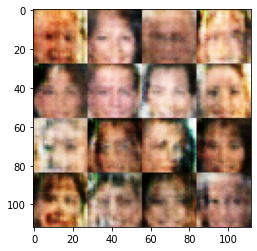

Epoch 1/1... Generator Loss: 0.6710 Discriminator Loss: 1.3352...
Epoch 1/1... Generator Loss: 0.7122 Discriminator Loss: 1.3383...
Epoch 1/1... Generator Loss: 0.6219 Discriminator Loss: 1.4584...
Epoch 1/1... Generator Loss: 0.7540 Discriminator Loss: 1.3998...
Epoch 1/1... Generator Loss: 0.8467 Discriminator Loss: 1.2129...
Epoch 1/1... Generator Loss: 0.8169 Discriminator Loss: 1.3132...
Epoch 1/1... Generator Loss: 0.5318 Discriminator Loss: 1.3498...
Epoch 1/1... Generator Loss: 0.5524 Discriminator Loss: 1.4432...
Epoch 1/1... Generator Loss: 0.6546 Discriminator Loss: 1.3830...
Epoch 1/1... Generator Loss: 0.7303 Discriminator Loss: 1.3427...


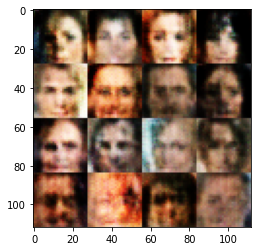

Epoch 1/1... Generator Loss: 0.5536 Discriminator Loss: 1.3480...
Epoch 1/1... Generator Loss: 0.7342 Discriminator Loss: 1.3282...
Epoch 1/1... Generator Loss: 0.4606 Discriminator Loss: 1.4475...
Epoch 1/1... Generator Loss: 0.6509 Discriminator Loss: 1.3411...
Epoch 1/1... Generator Loss: 0.5574 Discriminator Loss: 1.3903...
Epoch 1/1... Generator Loss: 0.8651 Discriminator Loss: 1.4676...
Epoch 1/1... Generator Loss: 0.5392 Discriminator Loss: 1.4077...
Epoch 1/1... Generator Loss: 0.6131 Discriminator Loss: 1.3945...
Epoch 1/1... Generator Loss: 0.5366 Discriminator Loss: 1.4127...
Epoch 1/1... Generator Loss: 0.7795 Discriminator Loss: 1.2908...


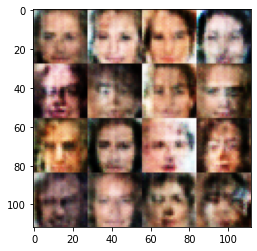

Epoch 1/1... Generator Loss: 0.6176 Discriminator Loss: 1.3952...
Epoch 1/1... Generator Loss: 0.6702 Discriminator Loss: 1.3966...
Epoch 1/1... Generator Loss: 0.6211 Discriminator Loss: 1.4295...
Epoch 1/1... Generator Loss: 0.8570 Discriminator Loss: 1.4721...
Epoch 1/1... Generator Loss: 0.4169 Discriminator Loss: 1.5443...
Epoch 1/1... Generator Loss: 0.6826 Discriminator Loss: 1.3576...
Epoch 1/1... Generator Loss: 0.5117 Discriminator Loss: 1.4260...
Epoch 1/1... Generator Loss: 0.8672 Discriminator Loss: 1.2220...
Epoch 1/1... Generator Loss: 0.7871 Discriminator Loss: 1.3215...
Epoch 1/1... Generator Loss: 0.7940 Discriminator Loss: 1.2166...


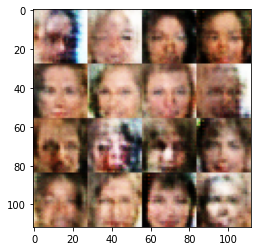

Epoch 1/1... Generator Loss: 0.5304 Discriminator Loss: 1.4083...
Epoch 1/1... Generator Loss: 0.6095 Discriminator Loss: 1.3589...
Epoch 1/1... Generator Loss: 0.4521 Discriminator Loss: 1.4452...
Epoch 1/1... Generator Loss: 0.5380 Discriminator Loss: 1.4064...
Epoch 1/1... Generator Loss: 0.6861 Discriminator Loss: 1.2565...
Epoch 1/1... Generator Loss: 0.7529 Discriminator Loss: 1.5097...
Epoch 1/1... Generator Loss: 0.3913 Discriminator Loss: 1.5531...
Epoch 1/1... Generator Loss: 0.5510 Discriminator Loss: 1.4568...
Epoch 1/1... Generator Loss: 0.6403 Discriminator Loss: 1.3348...
Epoch 1/1... Generator Loss: 0.7614 Discriminator Loss: 1.4776...


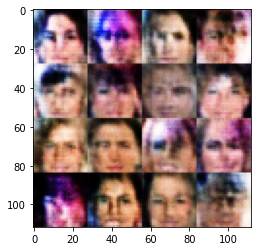

Epoch 1/1... Generator Loss: 0.7002 Discriminator Loss: 1.3516...
Epoch 1/1... Generator Loss: 0.6718 Discriminator Loss: 1.3571...
Epoch 1/1... Generator Loss: 0.5455 Discriminator Loss: 1.4308...
Epoch 1/1... Generator Loss: 0.6582 Discriminator Loss: 1.3225...
Epoch 1/1... Generator Loss: 0.6253 Discriminator Loss: 1.4173...
Epoch 1/1... Generator Loss: 0.4952 Discriminator Loss: 1.5237...
Epoch 1/1... Generator Loss: 0.5412 Discriminator Loss: 1.3780...
Epoch 1/1... Generator Loss: 0.4366 Discriminator Loss: 1.5486...
Epoch 1/1... Generator Loss: 0.5572 Discriminator Loss: 1.4126...
Epoch 1/1... Generator Loss: 0.6656 Discriminator Loss: 1.3546...


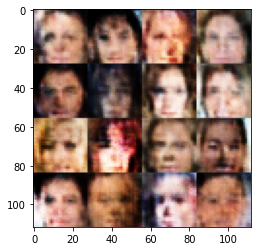

Epoch 1/1... Generator Loss: 0.3967 Discriminator Loss: 1.5321...
Epoch 1/1... Generator Loss: 0.4126 Discriminator Loss: 1.5329...
Epoch 1/1... Generator Loss: 0.5717 Discriminator Loss: 1.3749...
Epoch 1/1... Generator Loss: 0.5343 Discriminator Loss: 1.4697...
Epoch 1/1... Generator Loss: 0.6512 Discriminator Loss: 1.2527...
Epoch 1/1... Generator Loss: 0.7776 Discriminator Loss: 1.3555...
Epoch 1/1... Generator Loss: 0.8839 Discriminator Loss: 1.3689...
Epoch 1/1... Generator Loss: 0.6512 Discriminator Loss: 1.3268...
Epoch 1/1... Generator Loss: 0.7450 Discriminator Loss: 1.4594...
Epoch 1/1... Generator Loss: 0.6199 Discriminator Loss: 1.3999...


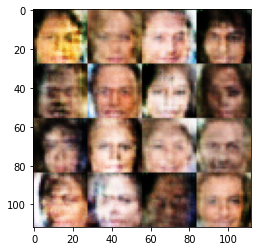

Epoch 1/1... Generator Loss: 0.5651 Discriminator Loss: 1.2458...
Epoch 1/1... Generator Loss: 0.5200 Discriminator Loss: 1.5226...
Epoch 1/1... Generator Loss: 0.5671 Discriminator Loss: 1.4237...
Epoch 1/1... Generator Loss: 0.6457 Discriminator Loss: 1.4475...
Epoch 1/1... Generator Loss: 0.5828 Discriminator Loss: 1.4228...
Epoch 1/1... Generator Loss: 0.5589 Discriminator Loss: 1.3621...
Epoch 1/1... Generator Loss: 0.7027 Discriminator Loss: 1.3089...
Epoch 1/1... Generator Loss: 0.5907 Discriminator Loss: 1.4149...
Epoch 1/1... Generator Loss: 0.7678 Discriminator Loss: 1.3082...
Epoch 1/1... Generator Loss: 0.6275 Discriminator Loss: 1.3300...


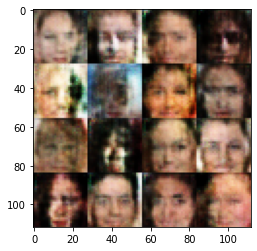

Epoch 1/1... Generator Loss: 0.6168 Discriminator Loss: 1.3392...
Epoch 1/1... Generator Loss: 0.5617 Discriminator Loss: 1.3652...
Epoch 1/1... Generator Loss: 0.6663 Discriminator Loss: 1.4131...
Epoch 1/1... Generator Loss: 0.6211 Discriminator Loss: 1.3996...
Epoch 1/1... Generator Loss: 0.6894 Discriminator Loss: 1.3769...
Epoch 1/1... Generator Loss: 0.6075 Discriminator Loss: 1.3364...
Epoch 1/1... Generator Loss: 0.7776 Discriminator Loss: 1.3337...
Epoch 1/1... Generator Loss: 0.6290 Discriminator Loss: 1.3597...
Epoch 1/1... Generator Loss: 0.8242 Discriminator Loss: 1.4784...
Epoch 1/1... Generator Loss: 0.6427 Discriminator Loss: 1.4059...


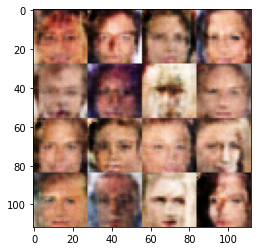

Epoch 1/1... Generator Loss: 0.6090 Discriminator Loss: 1.3864...
Epoch 1/1... Generator Loss: 0.4168 Discriminator Loss: 1.4840...
Epoch 1/1... Generator Loss: 0.6889 Discriminator Loss: 1.3888...
Epoch 1/1... Generator Loss: 0.6420 Discriminator Loss: 1.3708...
Epoch 1/1... Generator Loss: 0.7793 Discriminator Loss: 1.4695...
Epoch 1/1... Generator Loss: 0.5361 Discriminator Loss: 1.4670...
Epoch 1/1... Generator Loss: 0.6700 Discriminator Loss: 1.4035...
Epoch 1/1... Generator Loss: 0.6334 Discriminator Loss: 1.3601...
Epoch 1/1... Generator Loss: 0.7777 Discriminator Loss: 1.3723...
Epoch 1/1... Generator Loss: 0.6782 Discriminator Loss: 1.4112...


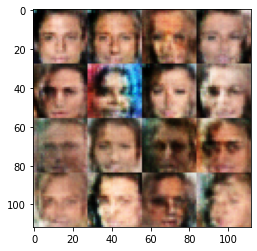

Epoch 1/1... Generator Loss: 0.4938 Discriminator Loss: 1.5293...
Epoch 1/1... Generator Loss: 0.5545 Discriminator Loss: 1.4903...
Epoch 1/1... Generator Loss: 0.6361 Discriminator Loss: 1.3432...
Epoch 1/1... Generator Loss: 0.7508 Discriminator Loss: 1.4443...
Epoch 1/1... Generator Loss: 0.7259 Discriminator Loss: 1.3937...
Epoch 1/1... Generator Loss: 0.5689 Discriminator Loss: 1.4805...
Epoch 1/1... Generator Loss: 0.5921 Discriminator Loss: 1.4053...
Epoch 1/1... Generator Loss: 0.6705 Discriminator Loss: 1.3739...
Epoch 1/1... Generator Loss: 0.4915 Discriminator Loss: 1.5901...
Epoch 1/1... Generator Loss: 0.4354 Discriminator Loss: 1.5530...


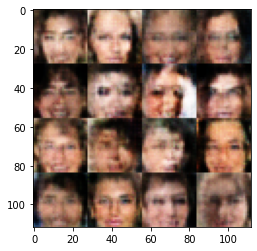

Epoch 1/1... Generator Loss: 0.5794 Discriminator Loss: 1.3482...
Epoch 1/1... Generator Loss: 0.8511 Discriminator Loss: 1.2555...
Epoch 1/1... Generator Loss: 0.4819 Discriminator Loss: 1.5157...
Epoch 1/1... Generator Loss: 0.6051 Discriminator Loss: 1.3909...
Epoch 1/1... Generator Loss: 0.8187 Discriminator Loss: 1.4041...
Epoch 1/1... Generator Loss: 0.6716 Discriminator Loss: 1.3986...
Epoch 1/1... Generator Loss: 0.6520 Discriminator Loss: 1.3061...
Epoch 1/1... Generator Loss: 0.6454 Discriminator Loss: 1.3505...
Epoch 1/1... Generator Loss: 0.6753 Discriminator Loss: 1.4152...
Epoch 1/1... Generator Loss: 0.5957 Discriminator Loss: 1.3256...


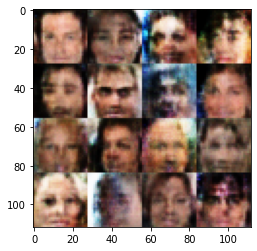

Epoch 1/1... Generator Loss: 0.6581 Discriminator Loss: 1.3438...
Epoch 1/1... Generator Loss: 0.6345 Discriminator Loss: 1.5044...
Epoch 1/1... Generator Loss: 0.6644 Discriminator Loss: 1.3873...
Epoch 1/1... Generator Loss: 0.8008 Discriminator Loss: 1.3310...
Epoch 1/1... Generator Loss: 0.3948 Discriminator Loss: 1.5835...
Epoch 1/1... Generator Loss: 0.7272 Discriminator Loss: 1.3042...
Epoch 1/1... Generator Loss: 0.5341 Discriminator Loss: 1.3985...
Epoch 1/1... Generator Loss: 0.5333 Discriminator Loss: 1.4186...
Epoch 1/1... Generator Loss: 0.5341 Discriminator Loss: 1.4217...
Epoch 1/1... Generator Loss: 0.5620 Discriminator Loss: 1.4358...


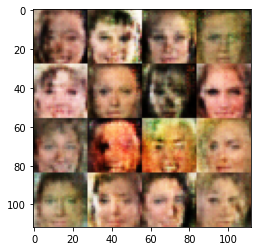

Epoch 1/1... Generator Loss: 0.7108 Discriminator Loss: 1.3023...
Epoch 1/1... Generator Loss: 0.6849 Discriminator Loss: 1.4465...
Epoch 1/1... Generator Loss: 0.7687 Discriminator Loss: 1.1857...
Epoch 1/1... Generator Loss: 0.6961 Discriminator Loss: 1.3232...
Epoch 1/1... Generator Loss: 0.5796 Discriminator Loss: 1.3480...
Epoch 1/1... Generator Loss: 0.6138 Discriminator Loss: 1.3564...
Epoch 1/1... Generator Loss: 0.4364 Discriminator Loss: 1.4801...
Epoch 1/1... Generator Loss: 0.6414 Discriminator Loss: 1.3084...
Epoch 1/1... Generator Loss: 0.6212 Discriminator Loss: 1.3750...
Epoch 1/1... Generator Loss: 0.6346 Discriminator Loss: 1.3772...


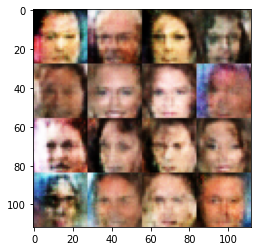

Epoch 1/1... Generator Loss: 0.6148 Discriminator Loss: 1.3849...
Epoch 1/1... Generator Loss: 0.5638 Discriminator Loss: 1.3945...
Epoch 1/1... Generator Loss: 0.6129 Discriminator Loss: 1.3835...
Epoch 1/1... Generator Loss: 0.9783 Discriminator Loss: 1.2755...
Epoch 1/1... Generator Loss: 0.6553 Discriminator Loss: 1.3683...
Epoch 1/1... Generator Loss: 0.6546 Discriminator Loss: 1.2665...
Epoch 1/1... Generator Loss: 0.7307 Discriminator Loss: 1.2642...
Epoch 1/1... Generator Loss: 0.8928 Discriminator Loss: 1.3463...
Epoch 1/1... Generator Loss: 0.6705 Discriminator Loss: 1.3389...
Epoch 1/1... Generator Loss: 0.5577 Discriminator Loss: 1.4545...


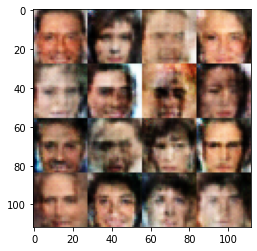

Epoch 1/1... Generator Loss: 0.5760 Discriminator Loss: 1.4252...
Epoch 1/1... Generator Loss: 0.6922 Discriminator Loss: 1.3396...
Epoch 1/1... Generator Loss: 0.6935 Discriminator Loss: 1.3461...
Epoch 1/1... Generator Loss: 0.5474 Discriminator Loss: 1.5015...
Epoch 1/1... Generator Loss: 0.6405 Discriminator Loss: 1.3718...
Epoch 1/1... Generator Loss: 0.6512 Discriminator Loss: 1.2745...
Epoch 1/1... Generator Loss: 0.7876 Discriminator Loss: 1.2713...
Epoch 1/1... Generator Loss: 0.6714 Discriminator Loss: 1.3345...
Epoch 1/1... Generator Loss: 0.5450 Discriminator Loss: 1.3681...
Epoch 1/1... Generator Loss: 0.3534 Discriminator Loss: 1.5600...


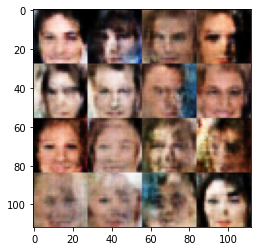

Epoch 1/1... Generator Loss: 0.6701 Discriminator Loss: 1.3936...
Epoch 1/1... Generator Loss: 0.6177 Discriminator Loss: 1.3957...
Epoch 1/1... Generator Loss: 0.6615 Discriminator Loss: 1.4294...
Epoch 1/1... Generator Loss: 0.6423 Discriminator Loss: 1.2704...
Epoch 1/1... Generator Loss: 0.7206 Discriminator Loss: 1.3182...
Epoch 1/1... Generator Loss: 0.6603 Discriminator Loss: 1.3926...
Epoch 1/1... Generator Loss: 0.6222 Discriminator Loss: 1.3497...
Epoch 1/1... Generator Loss: 0.4802 Discriminator Loss: 1.4423...
Epoch 1/1... Generator Loss: 0.3607 Discriminator Loss: 1.5597...
Epoch 1/1... Generator Loss: 0.6137 Discriminator Loss: 1.3682...


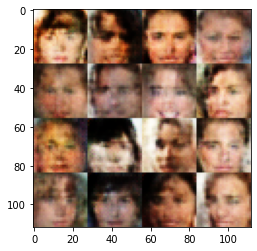

Epoch 1/1... Generator Loss: 0.8616 Discriminator Loss: 1.2933...
Epoch 1/1... Generator Loss: 0.6835 Discriminator Loss: 1.3225...
Epoch 1/1... Generator Loss: 0.5722 Discriminator Loss: 1.4623...
Epoch 1/1... Generator Loss: 0.4805 Discriminator Loss: 1.4226...
Epoch 1/1... Generator Loss: 0.5222 Discriminator Loss: 1.4131...
Epoch 1/1... Generator Loss: 0.7282 Discriminator Loss: 1.3409...
Epoch 1/1... Generator Loss: 0.7309 Discriminator Loss: 1.3605...
Epoch 1/1... Generator Loss: 0.6771 Discriminator Loss: 1.3829...
Epoch 1/1... Generator Loss: 0.6120 Discriminator Loss: 1.3244...
Epoch 1/1... Generator Loss: 0.9084 Discriminator Loss: 1.2589...


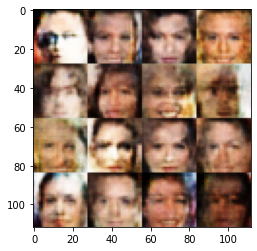

Epoch 1/1... Generator Loss: 1.0002 Discriminator Loss: 1.1540...
Epoch 1/1... Generator Loss: 0.8062 Discriminator Loss: 1.3271...
Epoch 1/1... Generator Loss: 0.7191 Discriminator Loss: 1.3135...
Epoch 1/1... Generator Loss: 0.6721 Discriminator Loss: 1.2376...
Epoch 1/1... Generator Loss: 0.7646 Discriminator Loss: 1.2426...
Epoch 1/1... Generator Loss: 0.5496 Discriminator Loss: 1.4349...
Epoch 1/1... Generator Loss: 0.6546 Discriminator Loss: 1.3415...
Epoch 1/1... Generator Loss: 0.5422 Discriminator Loss: 1.4217...
Epoch 1/1... Generator Loss: 0.7983 Discriminator Loss: 1.3285...
Epoch 1/1... Generator Loss: 0.6562 Discriminator Loss: 1.3965...


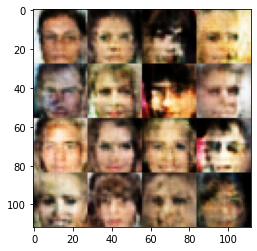

Epoch 1/1... Generator Loss: 0.8720 Discriminator Loss: 1.2977...
Epoch 1/1... Generator Loss: 0.6591 Discriminator Loss: 1.3325...
Epoch 1/1... Generator Loss: 0.6298 Discriminator Loss: 1.3442...
Epoch 1/1... Generator Loss: 0.9037 Discriminator Loss: 1.5281...
Epoch 1/1... Generator Loss: 0.7243 Discriminator Loss: 1.2988...
Epoch 1/1... Generator Loss: 0.5487 Discriminator Loss: 1.5195...
Epoch 1/1... Generator Loss: 0.6156 Discriminator Loss: 1.3002...
Epoch 1/1... Generator Loss: 0.6194 Discriminator Loss: 1.4387...
Epoch 1/1... Generator Loss: 0.5797 Discriminator Loss: 1.4247...
Epoch 1/1... Generator Loss: 0.6536 Discriminator Loss: 1.3281...


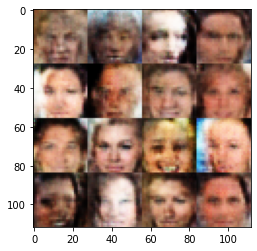

Epoch 1/1... Generator Loss: 0.5103 Discriminator Loss: 1.4329...
Epoch 1/1... Generator Loss: 0.6201 Discriminator Loss: 1.2972...
Epoch 1/1... Generator Loss: 0.9525 Discriminator Loss: 1.3079...
Epoch 1/1... Generator Loss: 0.6002 Discriminator Loss: 1.3100...
Epoch 1/1... Generator Loss: 0.5403 Discriminator Loss: 1.4445...
Epoch 1/1... Generator Loss: 0.6477 Discriminator Loss: 1.4604...
Epoch 1/1... Generator Loss: 0.5013 Discriminator Loss: 1.4870...
Epoch 1/1... Generator Loss: 0.6976 Discriminator Loss: 1.3947...
Epoch 1/1... Generator Loss: 0.6449 Discriminator Loss: 1.2690...
Epoch 1/1... Generator Loss: 0.7422 Discriminator Loss: 1.4030...


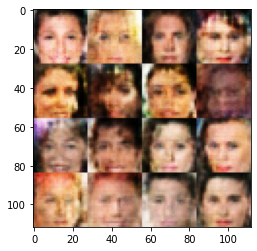

Epoch 1/1... Generator Loss: 0.5436 Discriminator Loss: 1.4102...
Epoch 1/1... Generator Loss: 0.7320 Discriminator Loss: 1.3961...
Epoch 1/1... Generator Loss: 0.5282 Discriminator Loss: 1.3747...
Epoch 1/1... Generator Loss: 0.6127 Discriminator Loss: 1.3835...
Epoch 1/1... Generator Loss: 0.5130 Discriminator Loss: 1.3780...
Epoch 1/1... Generator Loss: 0.4556 Discriminator Loss: 1.5699...
Epoch 1/1... Generator Loss: 0.7048 Discriminator Loss: 1.3737...
Epoch 1/1... Generator Loss: 0.6700 Discriminator Loss: 1.3232...
Epoch 1/1... Generator Loss: 0.6149 Discriminator Loss: 1.3312...
Epoch 1/1... Generator Loss: 0.4977 Discriminator Loss: 1.3958...


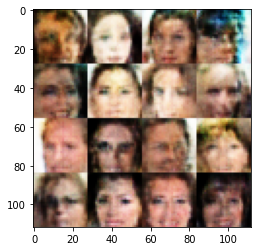

Epoch 1/1... Generator Loss: 0.3944 Discriminator Loss: 1.5237...
Epoch 1/1... Generator Loss: 0.6119 Discriminator Loss: 1.4029...
Epoch 1/1... Generator Loss: 0.6722 Discriminator Loss: 1.3082...
Epoch 1/1... Generator Loss: 0.5976 Discriminator Loss: 1.3456...
Epoch 1/1... Generator Loss: 0.6664 Discriminator Loss: 1.3011...
Epoch 1/1... Generator Loss: 0.6139 Discriminator Loss: 1.3963...
Epoch 1/1... Generator Loss: 0.6130 Discriminator Loss: 1.3104...
Epoch 1/1... Generator Loss: 0.6055 Discriminator Loss: 1.4250...
Epoch 1/1... Generator Loss: 0.5879 Discriminator Loss: 1.3450...
Epoch 1/1... Generator Loss: 0.4189 Discriminator Loss: 1.4451...


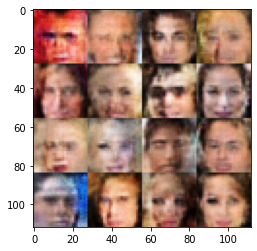

Epoch 1/1... Generator Loss: 0.6221 Discriminator Loss: 1.3596...
Epoch 1/1... Generator Loss: 0.6363 Discriminator Loss: 1.3599...
Epoch 1/1... Generator Loss: 0.6617 Discriminator Loss: 1.2812...
Epoch 1/1... Generator Loss: 0.7452 Discriminator Loss: 1.1605...
Epoch 1/1... Generator Loss: 0.7388 Discriminator Loss: 1.2899...
Epoch 1/1... Generator Loss: 0.7611 Discriminator Loss: 1.2605...


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.